# E-commerce Project - Logistic Regression
We are now going to look at training **logistic regression** with softmax. In my other walk throughs on logistic regression, we weren't looking at multiclass classification (just binary) so we had just been using the **sigmoid** function, and not softmax. This will give us the chance to see how logistic regression performs compared to a neural network. Remember, for logistic regression our architecture looks like:

<img src="images/logistic-neuron.png">

The only difference now is that instead of using the sigmoid at at the logistic neuron, we are going to use the softmax as we are performing multiclass classification. 

<img src="images/logistic-regression-softmax.png">

We can start with our imports.

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.utils import shuffle

And lets define our `get_data` function:

In [84]:
def get_data():
    df = pd.read_csv('data/ecommerce_data.csv')
    data = df.as_matrix()
    np.random.shuffle(data)
    X = data[:,:-1]
    Y = data[:,-1].astype(np.int32)

    # one-hot encode the categorical data
    N, D = X.shape
    X2 = np.zeros((N, D+3))
    X2[:,0:(D-1)] = X[:,0:(D-1)] # non-categorical

    # one-hot
    for n in range(N):
      t = int(X[n,D-1])
      X2[n,t+D-1] = 1
    X = X2

    # split train and test
    Xtrain = X[:-100]
    Ytrain = Y[:-100]
    Xtest = X[-100:]
    Ytest = Y[-100:]

    # normalize columns 1 and 2
    for i in (1, 2):
        m = Xtrain[:,i].mean()
        s = Xtrain[:,i].std()
        Xtrain[:,i] = (Xtrain[:,i] - m) / s
        Xtest[:,i] = (Xtest[:,i] - m) / s

    return Xtrain, Ytrain, Xtest, Ytest

We are going to need a function to get the indicator matrix from the targets.

In [85]:
def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N,K))
    for i in range(N):
        ind[i, y[i]] = 1 
    return ind

Now we can can get our data.

In [86]:
Xtrain, Ytrain, Xtest, Ytest = get_data()
D = Xtrain.shape[1]
K = len(set(Ytrain) | set(Ytest))

And convert our `Y` data into an indicator matrix. 

In [87]:
Ytrain_ind = y2indicator(Ytrain, K)
Ytest_ind = y2indicator(Ytest, K)

It is shape (400 x 4) because we have have four classes that make up Y. 

In [88]:
Ytrain_ind.shape

(400, 4)

Now randomly initialize our weights. 

In [89]:
W = np.random.randn(D, K)
b = np.zeros(K)

And we can define our `softmax` function:

In [90]:
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

And now lets define our forward function:

In [91]:
def forward(X, W, b):
    return softmax(X.dot(W) + b)

Next, our predict function:

In [92]:
def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

Our classification rate: 

In [93]:
def classification_rate(Y, P):
    return np.mean(Y == P)

And the **Cross Entropy**:

In [94]:
def cross_entropy(T, pY):
    return -np.mean(T * np.log(pY))

Now that we have done all of that, we can enter our train loop. Note: our weight update rule in gradient descent is based on the rule we derived last lecture: `Z.T.dot(T - Y)`. Only in the case of logistic regression, we only have and input and output layer, no hidden layer, so in this case `Z` is going to be `X`. We are also now going to be performing gradient descent, not ascent, so we have a minus in our update, and we are subtracting the targets from the predictions. 

0 0.8287540288489933 0.9003850880097086
1000 0.08418492580989106 0.09877722294675953
2000 0.07923753867491692 0.10139850040923776
3000 0.07719045310568866 0.10373858979302795
4000 0.07604902366182016 0.10564351295948805
5000 0.07530733633539427 0.10723249481209322
6000 0.07477841812805448 0.1086005166937598
7000 0.07437732900015982 0.10980998523502873
8000 0.07405982776445376 0.1109014034374176
9000 0.07380048254100513 0.11190163364791904
('Final training classification rate: ', 0.915)
('Final testing classification rate: ', 0.92)


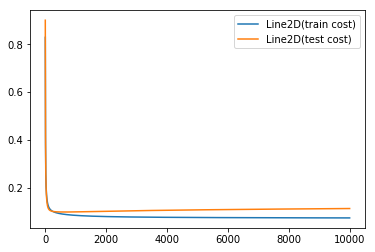

In [95]:
train_costs = []
test_costs = []
learning_rate = 0.001
for i in range(10000):
    pYtrain = forward(Xtrain, W, b)        # find the predicitons for y train
    pYtest = forward(Xtest, W, b)        # find the predicitons for y test
    
    ctrain = cross_entropy(Ytrain_ind, pYtrain)     # Ytrain_ind === targets in this case
    ctest = cross_entropy(Ytest_ind, pYtest)
    train_costs.append(ctrain)
    test_costs.append(ctest)
    
    # now we can perform gradient descent
    W -= learning_rate * Xtrain.T.dot(pYtrain - Ytrain_ind)  
    b -= learning_rate * (pYtrain - Ytrain_ind).sum(axis=0)
    if i % 1000 == 0:
        print i, ctrain, ctest
print("Final training classification rate: ", classification_rate(Ytrain, predict(pYtrain)))
print("Final testing classification rate: ", classification_rate(Ytest, predict(pYtest)))

legend1, = plt.plot(train_costs, label='train cost')
legend2, = plt.plot(test_costs, label='test cost')
plt.legend([legend1, legend2])
plt.show()

---
<br></br>
# Ecommerce Project - Training a Neural Network
Let's now look at how a neural network performs compared to logistic regression in this case. Again, lets start with our imports:

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.utils import shuffle

And again, we will want to define our y indicator function:

In [97]:
def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N,K))
    for i in range(N):
        ind[i, y[i]] = 1 
    return ind

And get our data:

In [98]:
Xtrain, Ytrain, Xtest, Ytest = get_data()

Now lets set the size of our **hidden layer**, and the size of our input layer:

In [99]:
M = 5
Xtrain.shape[1]
K = len(set(Ytrain) | set(Ytest))

And lets convert our Target labels into an indicator matrix:

In [100]:
Ytrain_ind = y2indicator(Ytrain, K)
Ytest_ind = y2indicator(Ytest, K)

Now randomly initialize our weights:

In [101]:
W1 = np.random.randn(D, M)
b1 = np.zeros(M)
W2 = np.random.randn(M, K)
b2 = np.zeros(K)

Next, define our softmax:

In [102]:
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

And now for the forward function. It is similar to the forward function from Logistic Regression, but notice that now have an additional layer to consider. Remember, Z is the output of hidden layer nodes, and we need to return Z because it is used in the derivative. 

Keep in mind, as we run through this prediction, when we first perform matrix multiplication between our input matrix $X$ and our first weight matrix $W_1$, each weight matrix is having the dot product performed against it. As we know, the more similar two vectors are, the greater their dot product.

In [103]:
def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)        
    return softmax(Z.dot(W2) + b2), Z   

Now lets redefine `predict` and `classification_rate`:

In [104]:
def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

def classification_rate(Y, P):
    return np.mean(Y == P)

And lets redefine cross entropy as well:

In [105]:
def cross_entropy(T, pY):
    return -np.mean(T * np.log(pY))

We can now enter our main training loop:

0 0.5126875082125257 0.5033229350006176
1000 0.023789503102607114 0.030832320756674064
2000 0.01777565901127042 0.02844900127489682
3000 0.015244805656697313 0.03166541215165763
4000 0.013798629163652527 0.034233345494632264
5000 0.01284864208951832 0.03603363683784785
6000 0.012146313286959549 0.03775309744522927
7000 0.011588070452292022 0.03948018261583864
8000 0.011123852587420522 0.041173504598982336
9000 0.010726973450467176 0.04278845938863183
('Final training classification rate: ', 0.9875)
('Final testing classification rate: ', 0.97)


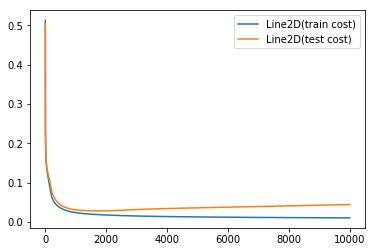

In [106]:
train_costs = []
test_costs = []
learning_rate = 0.001

for i in range(10000):
    pYtrain, Ztrain = forward(Xtrain, W1, b1, W2, b2)
    pYtest, Ztest = forward(Xtest, W1, b1, W2, b2)
    
    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    train_costs.append(ctrain)
    test_costs.append(ctest)
    
    # we can now start gradient descent
    W2 -= learning_rate * Ztrain.T.dot(pYtrain - Ytrain_ind)
    b2 -= learning_rate * (pYtrain - Ytrain_ind).sum(axis=0)
    # need to get error at the hidden node
    # note, (1 - Ztrain * Ztrain) is the derivative of tanh, if we had been using sigmoid
    # we would have it be (1 - Ztrain) * Ztrain
    dZ = (pYtrain - Ytrain_ind).dot(W2.T) * (1 - Ztrain * Ztrain) 
    # now we can update W1 and W2
    W1 -= learning_rate * Xtrain.T.dot(dZ)
    b1 -= learning_rate * dZ.sum(axis=0)
    
    if i % 1000 == 0:
        print i, ctrain, ctest
        
print("Final training classification rate: ", classification_rate(Ytrain, predict(pYtrain)))
print("Final testing classification rate: ", classification_rate(Ytest, predict(pYtest)))

legend1, = plt.plot(train_costs, label='train cost')
legend2, = plt.plot(test_costs, label='test cost')
plt.legend([legend1, legend2])
plt.show()